# Exploring Airnbnb NYC Listings Data
<p> The first step of the process before building our model is data exploration. We need to understand what kind of data we are dealing with. This includes exploring the number and type of features, distribution of predictors, and how certain features are related with our response. We will primarily focus on the listings data provided by Airbnb - however, we also use seasonality, reviews, and NYC transit data to better predict pricing for listings. The secondary datasets are examined later.</p>

### Import Libraries

In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline

In [33]:
# Global variables
BNB_BLUE = '#007A87'
BNB_RED = '#FF5A5F'
BNB_DARK_GRAY = '#565A5C'
BNB_LIGHT_GRAY = '#CED1CC'

### Initial Exploration
<p> We begin by examining `listings.csv` below. This is the primary dataset for Airbnb listings in New York City - it contains a number of categorical and quantitative features. Through exploration and analysis we will determine which ones will be useful to our model.</p>

In [34]:
# Read in the listings data 
listings = pd.read_csv('datasets/listings.csv', delimiter=',')

# View feature list
print listings.columns.values

['id' 'scrape_id' 'last_scraped' 'name' 'picture_url' 'host_id' 'host_name'
 'host_since' 'host_picture_url' 'street' 'neighbourhood'
 'neighbourhood_cleansed' 'city' 'state' 'zipcode' 'market' 'country'
 'latitude' 'longitude' 'is_location_exact' 'property_type' 'room_type'
 'accommodates' 'bathrooms' 'bedrooms' 'beds' 'bed_type' 'square_feet'
 'price' 'weekly_price' 'monthly_price' 'guests_included' 'extra_people'
 'minimum_nights' 'maximum_nights' 'calendar_updated' 'availability_30'
 'availability_60' 'availability_90' 'availability_365'
 'calendar_last_scraped' 'number_of_reviews' 'first_review' 'last_review'
 'review_scores_rating' 'review_scores_accuracy'
 'review_scores_cleanliness' 'review_scores_checkin'
 'review_scores_communication' 'review_scores_location'
 'review_scores_value' 'host_listing_count']


In [93]:
# Unsuppress Output
pd.options.display.max_columns = 5

# Split into predictor and response
y = listings[['price']]

# Append price at the end of the listings table
del listings['price']
listings = listings.join(y)

# Show listings dataframe
print 'Number of entries: ', listings.shape[0]
print 'Number of features: ', listings.shape[1] - 1
listings.head(n = 3)

Number of entries:  27392
Number of features:  51


,id,scrape_id,...,host_listing_count,price
0,1069266,2.015010e+13,...,1,$160.00
1,1846722,2.015010e+13,...,2,$105.00
2,2061725,2.015010e+13,...,4,$58.00


### Price Distribution of Listings
<p>The core listings dataset is comprised of 27,392 entries of Airbnb listing data with 51 total features including `bedrooms`, `bathrooms`, `room_type`, `review_score`, and more. We first examine the listings by price to get an initial impression of distribution.</p>

In [36]:
# plot_hist
# Function to plot histograms
#
# Input: n (integer for subplots)
#        titles (list of titles)
#        ranges (list of values)
# Output: None
def plot_hist(n, titles, ranges):
    fig, ax = plt.subplots(n, figsize = (8, 7.5))
    for i in range(n):
        d, bins, patches = ax[i].hist(ranges[i], 50, normed = 1, color= BNB_RED, alpha = 0.85)
        ax[i].set_title(titles[i])
        ax[i].set_xlabel("Daily Listing Price in Dollars")
        ax[i].set_ylabel("Frequency")
    plt.tight_layout()
    plt.show()

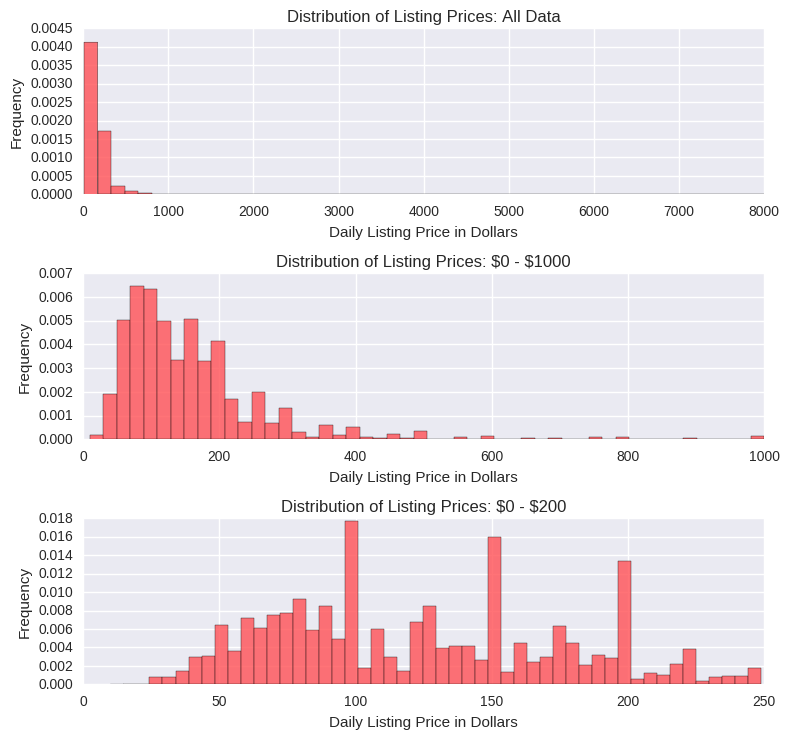

In [37]:
# Visualize price table, changing them to floats and replacing the commas with a blank
prices = listings['price'].apply(lambda s: float(s[1:].replace(',','')))

# Plot histograms of price distribution
plot_hist(3, ['Distribution of Listing Prices: All Data', 'Distribution of Listing Prices: \$0 - \$1000', 
               'Distribution of Listing Prices: \$0 - \$200'], [prices, prices[prices <= 1000], prices[prices < 250]])

<p>Above we see that prices are right skewed - most listings are below \$500 a night. Examining the price bucket \$0-\$200 (which has the vast majority of the listings) we see that listings also tend to be most frequently priced at \$100, \$150, and \$200.</p>

### Listing Clustering from Features
<p>The right-skewness above indicates that there is likely features causing clustering in our data. Intuitively, we believe bedrooms and location can have a large impact on the price of a listing, especially in New York City. We examine this below by exploring the `bedrooms` feature as well as the relationship between geographical location and price.</p>

#### Distribution of Listings by Bedrooms Count

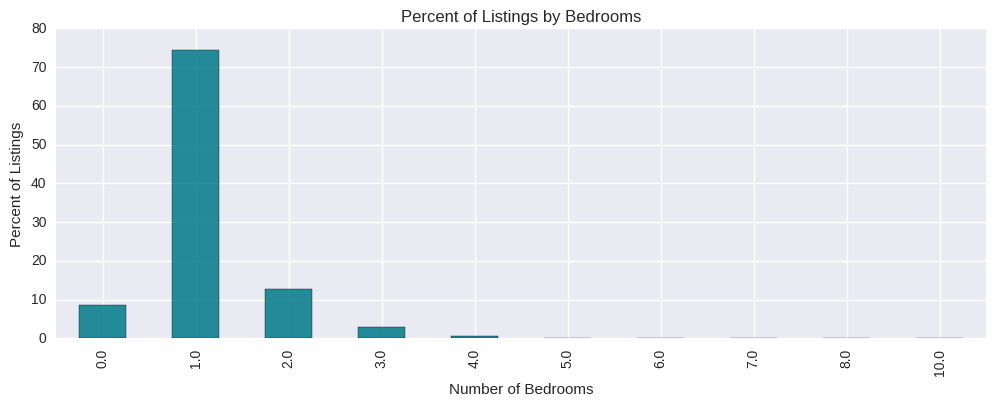

Percent of 1 Bedroom Listings: %74.31


In [38]:
# Get frequency of bedroom number for listings
bedrooms_counts = Counter(listings.bedrooms)
tdf = pd.DataFrame.from_dict(bedrooms_counts, orient = 'index').sort_values(by = 0)
tdf = (tdf.iloc[-10:, :] / 27392) * 100

# Sort bedroom dataframe by number
tdf.sort_index(axis = 0, ascending = True, inplace = True)

# Plot percent of listings by bedroom number
ax = tdf.plot(kind = 'bar', figsize = (12, 4), color = BNB_BLUE, alpha = 0.85)
ax.set_xlabel("Number of Bedrooms")
ax.set_ylabel("Percent of Listings")
ax.set_title('Percent of Listings by Bedrooms')
ax.legend_.remove()

plt.show()

print "Percent of 1 Bedroom Listings: %{0:.2f}".format(tdf[0][1])

<p>First we look at the `bedrooms` feature. As expected, we see that the majority of the listings are one-bedroom listings. This explains some of the right-skewness - smaller listings with less bedrooms will likely be priced cheaper than larger ones. But how important is location in influencing the price of a feature? Below we look at listings over low, medium, and high price buckets over NYC.</p>

#### Distribution of Listings by Geographical Location

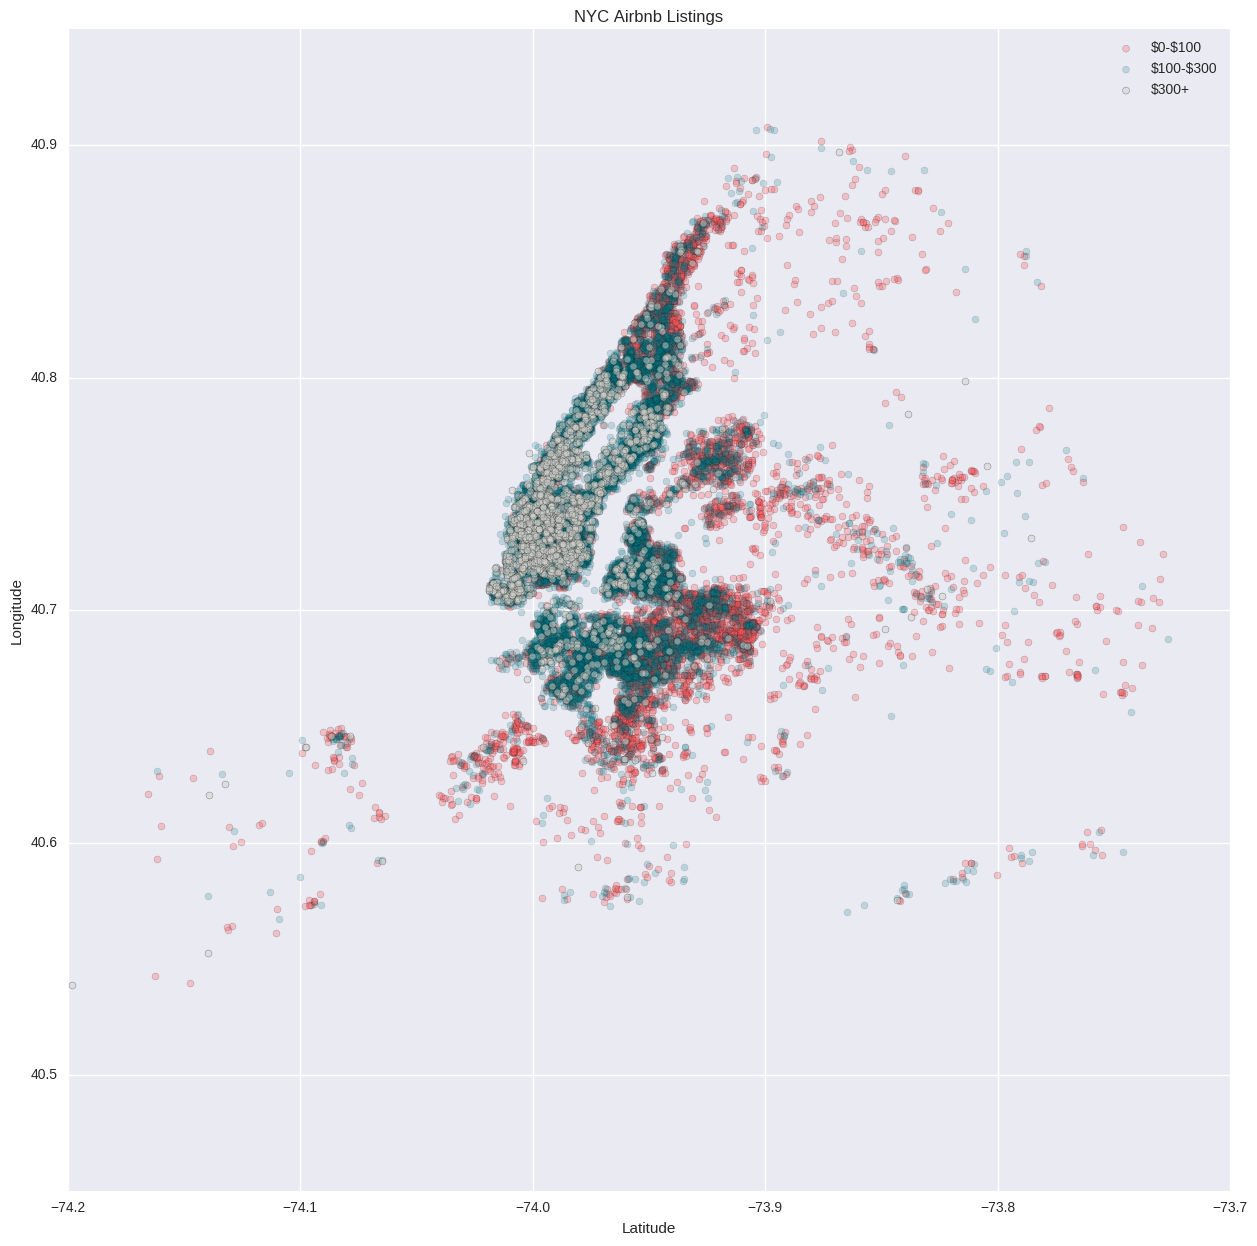

In [78]:
# Outline price buckets
intervals = [0,100,300, 10000]
leg_labels = []

# Get Labels for legend
for i in range(0,len(intervals) - 1):
    if i == len(intervals) - 2:
        leg_labels.append('\${}+'.format(intervals[i]))
    else:
        leg_labels.append("\${}-\${}".format(intervals[i], intervals[i+1]))    

buckets = []

# Divide up into price buckets
for i in range(0, len(intervals) - 1):
    buckets.append(listings[(prices > intervals[i]) & (prices < intervals[i+1])])

colors = [BNB_RED, BNB_BLUE, BNB_LIGHT_GRAY]
alphas = [.3,.2,.5,1,.4,.2]  

# Plot listings on scatterplot
plt.figure(figsize=(15, 15))
for i in range(0, len(buckets)):
    plt.scatter(buckets[i]['longitude'], buckets[i]['latitude'], alpha = alphas[i], c=colors[i], s=25)
    
plt.title('NYC Airbnb Listings')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.legend(labels=leg_labels, loc = 'best')
plt.xlim(-74.2,-73.7)
plt.ylim(40.45,40.95)

plt.show()

<p>The figure above depicts an interesting trend - the farther listings get from Manhattan, the less expensive they get. The most expensive listings are all around Central Park or on the lower end of Manhattan. North Manhattan, however, seems to be an exception with lower priced listings still very close to Central Park. Perhaps a feature containing proximity from Central Park could be beneficial in more accurately predicting prices.